In [1]:
# Basic Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import h5py

import svmbir

import spekpy as sp  # Import SpekPy
from xspec.chem_consts import get_lin_att_c_vs_E
from xspec.chem_consts._periodictabledata import density
from xspec.dict_gen import gen_filts_specD, gen_scints_specD

In [2]:
from xspec.dictSE import cal_fw_mat

In [3]:
src_spec_list = []
src_info = []
simkV_list = np.linspace(30, 160, 14, endpoint=True).astype('int')
max_simkV = max(simkV_list)
energies = np.linspace(1, max_simkV, max_simkV)
print('\nRunning demo script (1 mAs, 100 cm)\n')
for simkV in simkV_list:
    for th in [12]:
        s = sp.Spek(kvp=simkV + 1, th=th, dk=1, char=True)  # Create the spectrum model
        k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum
        src_info.append((simkV,))
        src_spec = np.zeros((max_simkV))
        src_spec[:simkV] = phi_k[::2]
        src_spec_list.append(src_spec)

print('\nFinished!\n')


Running demo script (1 mAs, 100 cm)


Finished!



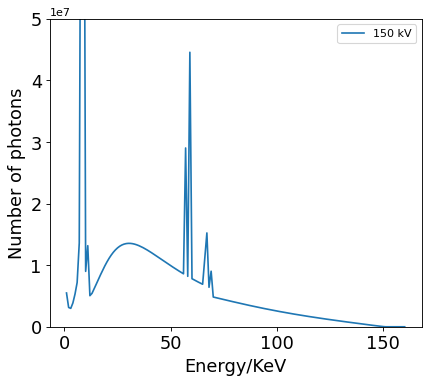

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=80)
axs.plot(energies, src_spec_list[12], label = '150 kV')
# axs.plot(energies, src_spec_list[9], label = '120 kV')
# Setting the title and labels with a font size of 16
# axs.set_title('A source spectral response', fontsize=16)
axs.set_xlabel('Energy/KeV', fontsize=16)
axs.set_ylabel('Number of photons', fontsize=16)

# Adjusting the font size of the tick labels to 16
axs.tick_params(axis='both', which='major', labelsize=16)

plt.ylim((0,5e7))
plt.legend()
plt.show()

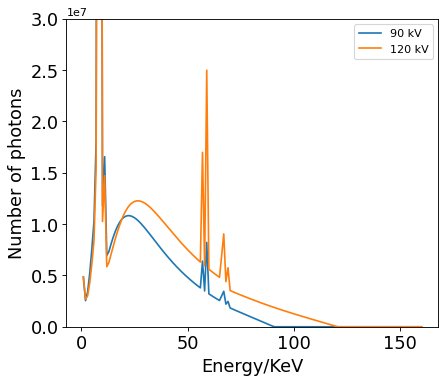

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=80)
axs.plot(energies, src_spec_list[6], label = '90 kV')
axs.plot(energies, src_spec_list[9], label = '120 kV')
# Setting the title and labels with a font size of 16
# axs.set_title('A source spectral response', fontsize=16)
axs.set_xlabel('Energy/KeV', fontsize=16)
axs.set_ylabel('Number of photons', fontsize=16)

# Adjusting the font size of the tick labels to 16
axs.tick_params(axis='both', which='major', labelsize=16)

plt.ylim((0,3e7))
plt.legend()
plt.show()

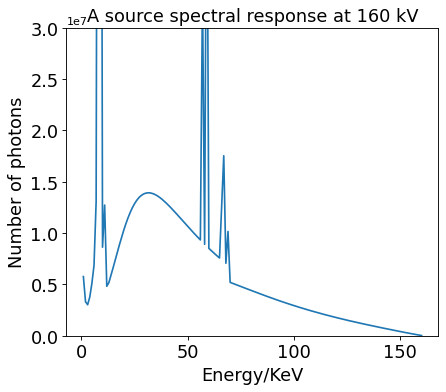

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming src_spec_list and energies are defined somewhere earlier in your code

fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=80)

# This will serve as the initializer function for the animation
def init():
    axs.set_xlim([min(energies), max(energies)])
    axs.set_ylim([0, 3e7])
    axs.set_xlabel('Energy/KeV', fontsize=16)
    axs.set_ylabel('Number of photons', fontsize=16)
    axs.tick_params(axis='both', which='major', labelsize=16)

# This function will be called for each frame of the animation
def update(frame):
    axs.clear()  # Clear the current frame
    voltage = 30 + frame * 10  # Voltage values from 30 kV to 160 kV with a step size of 10
    axs.set_title(f'A source spectral response at {voltage} kV', fontsize=16)
    axs.set_xlabel('Energy/KeV', fontsize=16)
    axs.set_ylabel('Number of photons', fontsize=16)
    axs.tick_params(axis='both', which='major', labelsize=16)
    axs.set_ylim([0, 3e7])
    axs.plot(energies, src_spec_list[frame])  # Plot the new data

# Create the animation object
ani = FuncAnimation(fig, update, frames=len(src_spec_list), init_func=init)

# Save the animation as a GIF (requires ImageMagick)
ani.save('animation.gif', writer='imagemagick')

plt.show()


In [7]:
src_spec_list_sub = src_spec_list[::3]

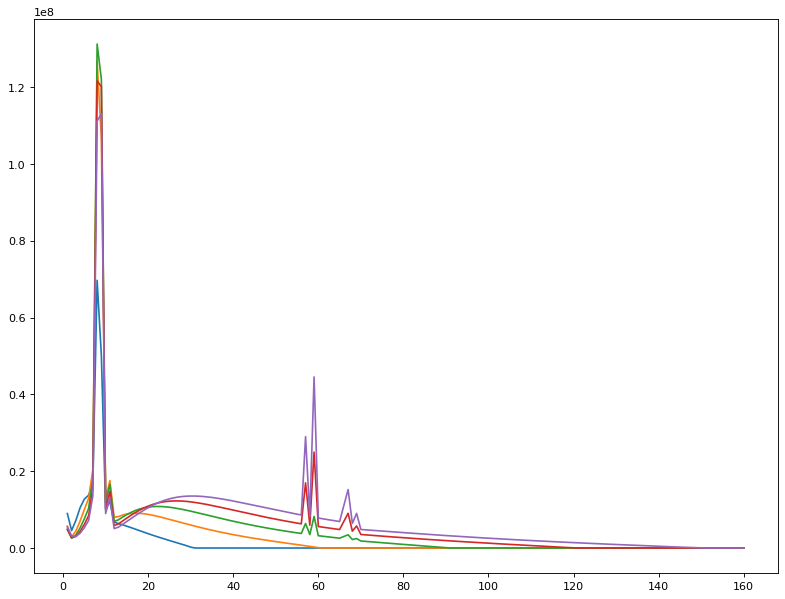

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(12, 9), dpi=80)
for ssl in src_spec_list_sub:
    plt.plot(energies, ssl)

## Prepare dataset


Running demo script (1 mAs, 100 cm)


Finished!

(160, 19600)


<Figure size 640x480 with 0 Axes>

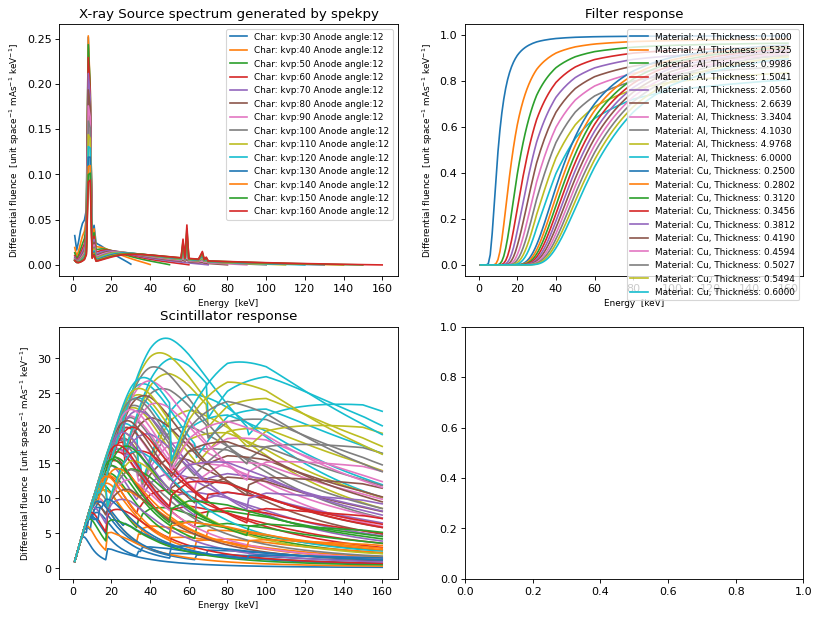

In [9]:
# Basic Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

import svmbir

import spekpy as sp # Import SpekPy
import xspec
from xspec.chem_consts import get_lin_att_c_vs_E
from xspec.chem_consts._periodictabledata import density
from xspec.dict_gen import gen_filts_specD, gen_scints_specD



def find_element_change_indexes(lst):
    start_indexes = [0]
    current_element = lst[0]

    for i in range(1, len(lst)):
        if lst[i] != current_element:
            start_indexes.append(i)
            current_element = lst[i]

    return start_indexes

def find_bin_index(number, sorted_list):
    left, right = 0, len(sorted_list) - 1

    while left <= right:
        mid = (left + right) // 2
        if sorted_list[mid] <= number:
            left = mid + 1
        else:
            right = mid - 1

    return right

def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    y_range = np.sqrt(np.mean((y_true ) ** 2))
    return rmse / y_range


def neg_log_space(vmin, vmax, num, scale=1):
    """
    vmin, vmax must be positive.
    """
    return np.abs(-np.log(np.linspace(np.exp(-vmin / vmax / scale), np.exp(-vmax / vmax / scale), num=num))) * vmax *scale

def get_dict_info(dict_index, src_info, fltr_info_dict, scints_info_dict):
    src_len = len(src_info)
    fltr_len = len(fltr_info_dict)
    scint_len = len(scints_info_dict)

    print(src_info[dict_index // (fltr_len * scint_len)])
    print(fltr_info_dict[dict_index // scint_len % fltr_len])
    print(scints_info_dict[dict_index % scint_len])


class Gen_Circle:
    def __init__(self, canvas_shape, pixel_size):
        """
        Initialize the Circle class.

        Parameters:
        canvas_shape (tuple): The shape of the canvas, in pixels.
        pixel_size (tuple): The size of a pixel, in the same units as the canvas.
        """
        self.canvas_shape = canvas_shape
        self.pixel_size = pixel_size
        self.canvas_center = ((canvas_shape[0] - 1) / 2.0, (canvas_shape[1] - 1) / 2.0,)

    def generate_mask(self, radius, center=None):
        """
        Generate a binary mask for the circle.

        Parameters:
        radius (int): The radius of the circle, in pixels.
        center (tuple): The center of the circle.

        Returns:
        ndarray: A 2D numpy array where points inside the circle are marked as True and points outside are marked as False.
        """
        if center is None:
            center = ((self.canvas_shape[0] - 1) / 2.0, (self.canvas_shape[1] - 1) / 2.0)

        # Generate a grid of coordinates in the shape of the mask.
        Y, X = np.ogrid[:self.canvas_shape[0], :self.canvas_shape[1]]
        X = X - self.canvas_center[1]
        Y = Y - self.canvas_center[0]

        # Scale the coordinates by the pixel size.
        X = X * self.pixel_size[1]
        Y = Y * self.pixel_size[0]

        # Calculate the distance from the center to each coordinate.
        dist_from_center = np.sqrt((X - center[1]) ** 2 + (Y - center[0]) ** 2)

        # Create a mask where points with a distance less than or equal to the radius are marked as True.
        mask = dist_from_center <= radius

        # Calculate the radius of the largest circle that can be inscribed in the canvas.
        inscribed_circle_radius = min(self.canvas_shape) // 2

        # Check if the mask is outside the inscribed circle.
        if radius > inscribed_circle_radius:
            warnings.warn("The generated mask falls outside the largest inscribed circle in the canvas.")

        return mask


# Customerize forward projector.
class pt_fw_projector:
    def __init__(self, angles, num_channels, delta_pixel=1, geometry='parallel'):
        """

        Parameters
        ----------
        energies
        N_views
        psize
        xcenter
        geometry
        arange
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel
        self.geometry = geometry

    def forward(self, mask):
        """

        Parameters
        ----------
        mask : numpy.ndarray
            3D mask for pure solid object.

        Returns
        -------
        lai : numpy.ndarray
            Linear attenuation integral, of size M measurement * N energy bins.

        """

        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel

        return projections



    

os.makedirs('./output_exp18',exist_ok=True)
filename = 'exp18-reformat'

## A. Generate simulated cylinder
# rsize = [0.03125 / 6, 0.03125 / 24.0]  # mm
rsize = [0.03125 / 12.0, 0.03125 / 12.0, 0.03125 / 12.0]  # mm
nchanl = 1024
materials = ['Al', 'Ti', 'V']
Radius = [1, 1, 1]
centers = [0, 0]

# Simulated sinogram parameters
num_views = 9
tilt_angle = np.pi / 2  # Tilt range of +-90deg
# Generate the array of view angles
angles = np.linspace(-tilt_angle, tilt_angle, num_views, endpoint=False)

mask_scan = []
for mat_id, mat in enumerate(materials):
    mask_list = []
    circle = Gen_Circle((nchanl, nchanl), (rsize[mat_id], rsize[mat_id]))
    mask_list.append(circle.generate_mask(Radius[mat_id], centers)[np.newaxis])
    mask_scan.append(mask_list)

plt.clf()
src_spec_list = []
src_info = []
simkV_list = np.linspace(30, 160, 14, endpoint=True).astype('int')
max_simkV = max(simkV_list)
energies = np.linspace(1, max_simkV, max_simkV)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=80)
print('\nRunning demo script (1 mAs, 100 cm)\n')
for simkV in simkV_list:
    for th in [12]:
        s = sp.Spek(kvp=simkV + 1, th=th, dk=1, char=True)  # Create the spectrum model
        k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum

        ## Plot the x-ray spectrum
        axs[0, 0].plot(k[::2], phi_k[::2] / np.trapz(phi_k[::2], k[::2]),
                       label='Char: kvp:%d Anode angle:%d' % (simkV, th))
        src_info.append((simkV,))
        src_spec = np.zeros((max_simkV))
        src_spec[:simkV] = phi_k[::2]
        src_spec_list.append(src_spec)

print('\nFinished!\n')
axs[0, 0].set_xlabel('Energy  [keV]', fontsize=8)
axs[0, 0].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
axs[0, 0].set_title('X-ray Source spectrum generated by spekpy')
axs[0, 0].legend(fontsize=8)
src_spec_list = np.array(src_spec_list)

# Generate filter response
fltr_params = [
    {'formula': 'Al', 'density': 2.702, 'thickness_list': neg_log_space(vmin=0.1, vmax=6, num=10, scale=1), 'thickness_bound':(0,10)},
    {'formula': 'Cu', 'density': 8.92, 'thickness_list': neg_log_space(vmin=0.25, vmax=0.6, num=10, scale=1), 'thickness_bound':(0,2)},
]

fltr_dict, fltr_info_dict = gen_filts_specD(energies, composition=fltr_params)
for i, fltr in enumerate(fltr_dict):
    axs[0, 1].plot(energies[:max_simkV], fltr[:max_simkV],
                   label='Material: %s, Thickness: %.4f' % (fltr_info_dict[i][0],
                                                            fltr_info_dict[i][1]))
axs[0, 1].set_xlabel('Energy  [keV]', fontsize=8)
axs[0, 1].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
axs[0, 1].set_title('Filter response')
axs[0, 1].legend(fontsize=8)

# Scintillator model
scint_params = [
    {'formula': 'CsI', 'density': 4.51, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Lu3Al5O12', 'density': 6.73,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'CdWO4', 'density': 7.9, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Y3Al5O12', 'density': 4.56,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Bi4Ge3O12', 'density': 7.13,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Gd2O2S', 'density': 7.32, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)}
]

scints_dict, scints_info_dict = gen_scints_specD(energies, composition=scint_params)
for i, scints in enumerate(scints_dict):
    axs[1, 0].plot(energies[:max_simkV], scints[:max_simkV],
                   label='Material: %s, Thickness: %.2f' % (scints_info_dict[i][0],
                                                            scints_info_dict[i][1]))
axs[1, 0].set_xlabel('Energy  [keV]', fontsize=8)
axs[1, 0].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
axs[1, 0].set_title('Scintillator response')

spec_dict = src_spec_list[:, np.newaxis, np.newaxis, :] \
            * fltr_dict[np.newaxis, :, np.newaxis, :] \
            * scints_dict[np.newaxis, np.newaxis, :, :]

spec_dict = spec_dict.reshape(-1, spec_dict.shape[-1]).T
spec_dict_norm = spec_dict / np.trapz(spec_dict, energies, axis=0)
print(spec_dict.shape)
plt.savefig('./output_exp18/%s_dict.png'%filename)

Simulation Case with random seed =  71

Running demo script (1 mAs, 100 cm)

11
ref_fltr_formula: Cu
ref_fltr_thickness: 0.5156919888057541 In flter response list: 7
ref_scint_formula: CsI
ref_scint_thickness: 0.2552628194955748 In scintillator response list: 7
simkV: 40
Generate spectrum dictionary with shape:  (160, 1)

Finished!

simkV: 80
Generate spectrum dictionary with shape:  (160, 1)

Finished!

simkV: 120
Generate spectrum dictionary with shape:  (160, 1)

Finished!

simkV: 150
Generate spectrum dictionary with shape:  (160, 1)

Finished!

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/a29410cb5c158da5f30d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/a29410cb5c158da5f30d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/a29410cb5c158da5f30d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/a29410cb5c158da5f30d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/a29410cb5c158da5

<Figure size 640x480 with 0 Axes>

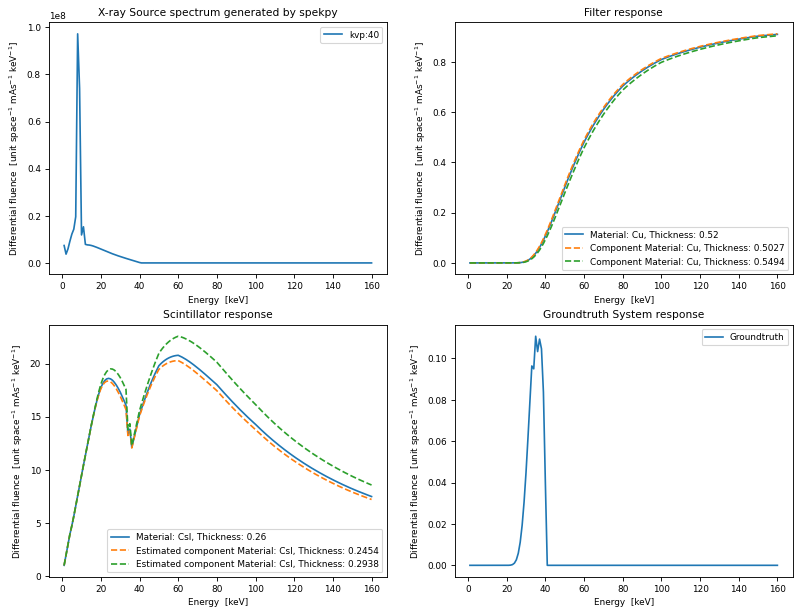

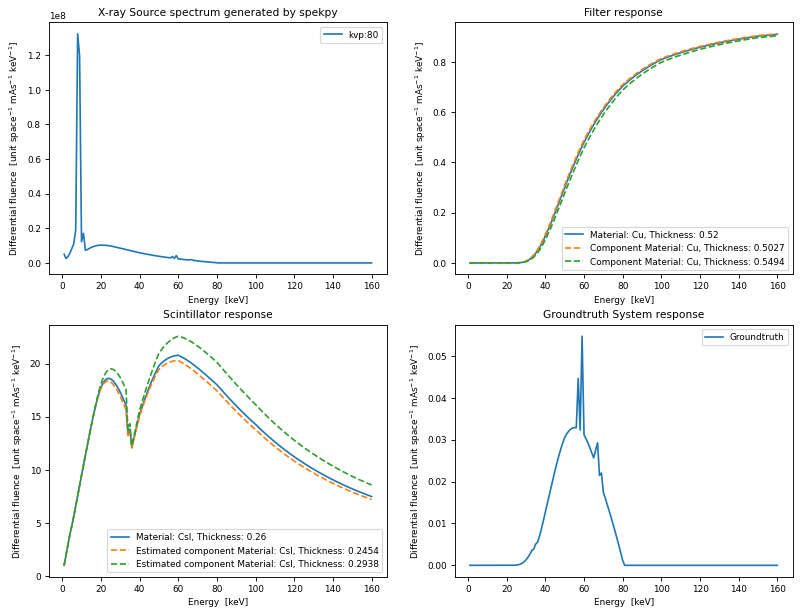

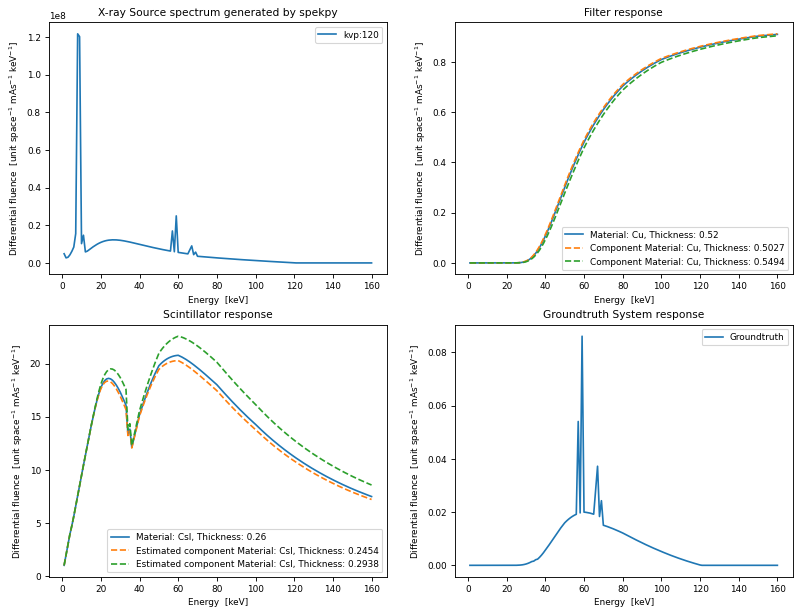

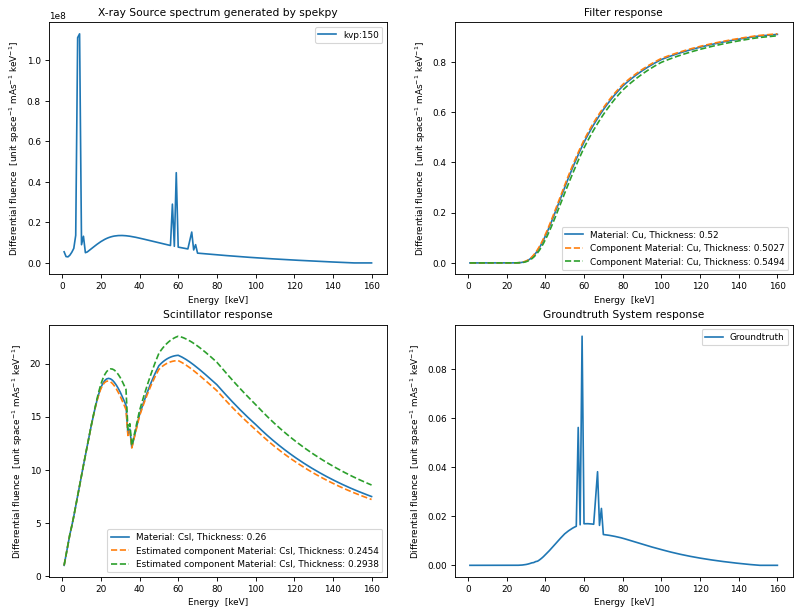

In [10]:
for rand_seed_num in [71]:
    print('Simulation Case with random seed = ', rand_seed_num)
    plt.clf()
    np.random.seed(rand_seed_num)
    ref_src_spec_list = []
    ref_src_info = []

    #     fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=80)
    plt.rcParams.update({'font.size': 8})
    print('\nRunning demo script (1 mAs, 100 cm)\n')
    ## Generate spectrum for 100 kV potential, 10 deg. anode angle & 6 mm Al filtr.
    # for th in (np.exp(np.linspace(0,1.6,5))*6).astype('int'):
#     simkV_list_indices = np.random.choice(np.arange(len(simkV_list)))
    simkV_list_indices = np.array([1, 5, 9, 12])

    # Generate filter response
    fltr_formular_list = [fid[0] for fid in fltr_info_dict]
    sorted_fltr_formular_indice_list = find_element_change_indexes(fltr_formular_list)
    rand_flter_formula_ind = np.random.choice(np.arange(len(fltr_formular_list)))
    print(rand_flter_formula_ind)
    ref_fltr_formula_indices = find_bin_index(rand_flter_formula_ind, sorted_fltr_formular_indice_list)

    ref_fltr_formula = fltr_params[ref_fltr_formula_indices]['formula']
    ref_fltr_formula_density = fltr_params[ref_fltr_formula_indices]['density']
    if ref_fltr_formula_indices == 2:
        ref_fltr_thickness = 0
    elif ref_fltr_formula_indices == 0:
        ref_fltr_thickness = np.random.uniform(0.1, 6)
    elif ref_fltr_formula_indices == 1:
        ref_fltr_thickness = np.random.uniform(0.25, 0.6)
    print('ref_fltr_formula:', ref_fltr_formula)
    print('ref_fltr_thickness:', ref_fltr_thickness, 'In flter response list:',
          find_bin_index(ref_fltr_thickness, fltr_params[ref_fltr_formula_indices]['thickness_list']))

    ref_fltr_params = [
        {'formula': ref_fltr_formula, 'density': ref_fltr_formula_density, 'thickness_list': [ref_fltr_thickness]},
    ]
    ref_fltr_dict, ref_fltr_info_dict = gen_filts_specD(energies, composition=ref_fltr_params)

    # Scintillator model
    scint_formula_list = [param['formula'] for param in scint_params]
    ref_scint_formula_indices = np.random.choice(np.arange(len(scint_formula_list)))
    ref_scint_formula = scint_params[ref_scint_formula_indices]['formula']
    ref_scint_formula_density = scint_params[ref_scint_formula_indices]['density']
    ref_scint_thickness = np.random.uniform(0.02, 0.35)
    print('ref_scint_formula:', ref_scint_formula)
    print('ref_scint_thickness:', ref_scint_thickness, 'In scintillator response list:',
          find_bin_index(ref_scint_thickness, scint_params[ref_scint_formula_indices]['thickness_list']))

    ref_scint_params = [
        {'formula': ref_scint_formula, 'density': ref_scint_formula_density,
         'thickness_list': [ref_scint_thickness]}]
    ref_scints_dict, ref_scints_info_dict = gen_scints_specD(energies, composition=ref_scint_params)

    ref_spec_simkv_list = []
    gt_spec_simkv_list = []

    for simkV, sli in zip(simkV_list[simkV_list_indices], simkV_list_indices):
        fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=80)
        plt.rcParams.update({'font.size': 8})
        ref_src_spec_list = []
        ref_src_info = []
        print('simkV:', simkV)

        ## Plot the x-ray spectrum
        ref_src_info.append(simkV)
        ref_src_spec_list = np.array([src_spec_list[sli]])

        axs[0, 0].plot(energies, src_spec_list[sli], label='kvp:%d' % (simkV))
        axs[0, 0].set_xlabel('Energy  [keV]', fontsize=8)
        axs[0, 0].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
        axs[0, 0].set_title('X-ray Source spectrum generated by spekpy')
        axs[0, 0].legend()

        # Generate filter response
        axs[0, 1].plot(energies[:max_simkV], ref_fltr_dict[0, :max_simkV],
                       label='Material: %s, Thickness: %.2f' % (ref_fltr_info_dict[0][0],
                                                                ref_fltr_info_dict[0][1]))
        axs[0, 1].set_xlabel('Energy  [keV]', fontsize=8)
        axs[0, 1].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
        axs[0, 1].set_title('Filter response')

        fbini = find_bin_index(ref_fltr_thickness, fltr_params[ref_fltr_formula_indices][
            'thickness_list']) + ref_fltr_formula_indices * 10
        for fli in [fbini, fbini + 1]:
            axs[0, 1].plot(energies[:max_simkV], fltr_dict[fli], '--',
                           label='Component Material: %s, Thickness: %.4f' % (fltr_info_dict[fli][0],
                                                                              fltr_info_dict[fli][1]))
        axs[0, 1].legend()

        # Scintillator model
        axs[1, 0].plot(energies[:max_simkV], ref_scints_dict[0, :max_simkV],
                       label='Material: %s, Thickness: %.2f' % (ref_scints_info_dict[0][0],
                                                                ref_scints_info_dict[0][1]))
        axs[1, 0].set_xlabel('Energy  [keV]', fontsize=8)
        axs[1, 0].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
        axs[1, 0].set_title('Scintillator response')
        sbini = find_bin_index(ref_scint_thickness, scint_params[ref_scint_formula_indices][
            'thickness_list']) + ref_scint_formula_indices * 10
        for sci in [sbini, sbini + 1]:
            axs[1, 0].plot(energies[:max_simkV], scints_dict[sci], '--',
                           label='Estimated component Material: %s, Thickness: %.4f' % (scints_info_dict[sci][0],
                                                                                        scints_info_dict[sci][1]))
        axs[1, 0].legend()

        gt_spec_dict = ref_src_spec_list[:, np.newaxis, np.newaxis, :] \
                       * ref_fltr_dict[np.newaxis, :, np.newaxis, :] \
                       * ref_scints_dict[np.newaxis, np.newaxis, :, :]
        gt_spec_dict = gt_spec_dict.reshape((-1, gt_spec_dict.shape[-1])).T
        gt_spec_dict /= np.trapz(gt_spec_dict, energies, axis=0)
        ref_spec_simkv_list.append(ref_src_spec_list)
        gt_spec_simkv_list.append(gt_spec_dict)
        print('Generate spectrum dictionary with shape: ', gt_spec_dict.shape)

        axs[1, 1].plot(energies[:max_simkV], gt_spec_dict[:max_simkV], label='Groundtruth')
        axs[1, 1].set_xlabel('Energy  [keV]', fontsize=8)
        axs[1, 1].set_ylabel('Differential fluence  [unit space$^{-1}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
        axs[1, 1].set_title('Groundtruth System response')
        axs[1, 1].legend()
        print('\nFinished!\n')
        plt.savefig('./output_exp15/exp3_%s_gt_sv%d_%d.png' % (filename, simkV, rand_seed_num))

    # D. Prepare forward matrix F
    simkV_spec_F_train_list = []
    simkV_signal_train_list = []
    for simkV, gt_spec_dict in zip(simkV_list[simkV_list_indices],gt_spec_simkv_list):

        spec_F_train_list = []
        proj_list = []

        for mat_id, mat in enumerate(materials):
            lac_vs_E_list = []
            mask_list = mask_scan[mat_id]
            for i in range(len(mask_list)):
                formula = mat
                den = density['%s' % formula]
                lac_vs_E_list.append(get_lin_att_c_vs_E(den, formula, energies))

            pfp = pt_fw_projector(angles, num_channels=nchanl, delta_pixel=rsize[mat_id])
            spec_F = cal_fw_mat(mask_list, lac_vs_E_list, energies, pfp)
            proj = np.trapz(spec_F * gt_spec_dict.flatten(), energies, axis=-1)
            proj_list.append(proj)
            spec_F_train = spec_F.reshape((-1, spec_F.shape[-1]))
            spec_F_train_list.append(spec_F_train)

        spec_F_train_list = np.array(spec_F_train_list)
        proj_list = np.array(proj_list)
        npt = 0.01
        proj_n_list = [proj + np.sqrt(proj) * np.random.normal(0, npt, size=proj.shape) for proj in proj_list]

        spec_F_train = [spec_F.reshape((-1, spec_F.shape[-1])) for spec_F in spec_F_train_list]
        signal_train = proj_n_list

        simkV_spec_F_train_list.append(spec_F_train)
        simkV_signal_train_list.append(proj_n_list)

In [11]:
ref_fltr_params

[{'formula': 'Cu', 'density': 8.92, 'thickness_list': [0.5156919888057541]}]

In [12]:
len(simkV_spec_F_train_list)

4

In [13]:
len(simkV_signal_train_list)

4

## Test model with source voltage

In [14]:
# Basic Packages
import os
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt
import argparse

import spekpy as sp # Import SpekPy
import xspec

from xspec.dict_gen import gen_filts_specD, gen_scints_specD

In [15]:
def extract_rsn_from_path(path):
    match = re.search(r'_rsn_(\d+)', path)
    if match:
        return int(match.group(1))
    return None

def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    y_range = np.sqrt(np.mean((y_true ) ** 2))
    return rmse / y_range


def neg_log_space(vmin, vmax, num, scale=1):
    """
    vmin, vmax must be positive.
    """
    return np.abs(-np.log(np.linspace(np.exp(-vmin / vmax / scale), np.exp(-vmax / vmax / scale), num=num))) * vmax *scale

def read_hdf5(filename):
    data = {
        "gt_flter_param": {},
        "gt_scint_param": {},
        "data": []
    }

    with h5py.File(filename, 'r') as f:
        # Read dictionaries (groups)
        for key in f["gt_flter_param"].keys():
            data["gt_flter_param"][key] = f["gt_flter_param"][key][()]

        for key in f["gt_scint_param"].keys():
            data["gt_scint_param"][key] = f["gt_scint_param"][key][()]

        # Read data list (group of groups)
        for key in f["data"].keys():
            subgroup = f["data"][key]
            data_dict = {}
            for subkey in subgroup.keys():
                data_dict[subkey] = subgroup[subkey][()]
            data["data"].append(data_dict)

    return data

    


# Setup the argument parser
# dataset_path = '../sim_data/sim_dataset_rsn_41.h5'
rand_seed_num = 41
# data = read_hdf5(dataset_path)

simkV_list = np.linspace(30, 160, 14, endpoint=True).astype('int')
max_simkV = max(simkV_list)
energies = np.linspace(1, max_simkV, max_simkV)


# Generate filter response
fltr_params = [
    {'formula': 'Al', 'density': 2.702, 'thickness_list': neg_log_space(vmin=0.1, vmax=6, num=10, scale=1), 'thickness_bound':(0,10)},
    {'formula': 'Cu', 'density': 8.92, 'thickness_list': neg_log_space(vmin=0.25, vmax=0.6, num=10, scale=1), 'thickness_bound':(0,2)},
]


# Scintillator model
scint_params = [
    {'formula': 'CsI', 'density': 4.51, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Lu3Al5O12', 'density': 6.73,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'CdWO4', 'density': 7.9, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Y3Al5O12', 'density': 4.56,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Bi4Ge3O12', 'density': 7.13,
     'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)},
    {'formula': 'Gd2O2S', 'density': 7.32, 'thickness_list': neg_log_space(vmin=0.02, vmax=0.35, num=10, scale=1), 'thickness_bound':(0.02,0.5)}
]



In [16]:
gt_flter_param = ref_fltr_params[0]
gt_scint_param = ref_scint_params[0]

In [17]:
print(gt_flter_param)
print(gt_scint_param)

{'formula': 'Cu', 'density': 8.92, 'thickness_list': [0.5156919888057541]}
{'formula': 'CsI', 'density': 4.51, 'thickness_list': [0.2552628194955748]}


In [18]:
src_response_dict = []
for spec, kV in zip([src_spec_list[i] for i in range(14)], [simkV_list[i] for i in range(14)]):
    src_response_dict.append({'spectrum':spec,'source_voltage':kV})

In [19]:
signal_train_list = simkV_signal_train_list
spec_F_train_list = simkV_spec_F_train_list
# for svv in [40,80,150]:
#     signal_train = [data["data"][i]["measurement"] for i in range(len(data["data"])) if data["data"][i]["source_voltage"] == svv]
#     spec_F_train = [data["data"][i]["forward_mat"] for i in range(len(data["data"])) if data["data"][i]["source_voltage"] == svv]
#     signal_train_list.append(signal_train)
#     spec_F_train_list.append(spec_F_train)


In [20]:
scint_params

[{'formula': 'CsI',
  'density': 4.51,
  'thickness_list': array([0.02      , 0.04458472, 0.07102767, 0.0996329 , 0.13078576,
         0.16498484, 0.20289106, 0.24540694, 0.29381089, 0.35      ]),
  'thickness_bound': (0.02, 0.5)},
 {'formula': 'Gd3Al2Ga3O12',
  'density': 6.63,
  'thickness_list': array([0.02      , 0.04458472, 0.07102767, 0.0996329 , 0.13078576,
         0.16498484, 0.20289106, 0.24540694, 0.29381089, 0.35      ]),
  'thickness_bound': (0.02, 0.5)},
 {'formula': 'Lu3Al5O12',
  'density': 6.73,
  'thickness_list': array([0.02      , 0.04458472, 0.07102767, 0.0996329 , 0.13078576,
         0.16498484, 0.20289106, 0.24540694, 0.29381089, 0.35      ]),
  'thickness_bound': (0.02, 0.5)},
 {'formula': 'CdWO4',
  'density': 7.9,
  'thickness_list': array([0.02      , 0.04458472, 0.07102767, 0.0996329 , 0.13078576,
         0.16498484, 0.20289106, 0.24540694, 0.29381089, 0.35      ]),
  'thickness_bound': (0.02, 0.5)},
 {'formula': 'Y3Al5O12',
  'density': 4.56,
  'thickness

In [21]:
print(gt_flter_param)
print(gt_scint_param)

{'formula': 'Cu', 'density': 8.92, 'thickness_list': [0.5156919888057541]}
{'formula': 'CsI', 'density': 4.51, 'thickness_list': [0.2552628194955748]}


In [22]:
from xspec.paramSE import param_based_spec_estimate, spec_distrb_energy_resp
from xspec._defs import *
import torch

In [28]:
help(Source)

Help on class Source in module xspec._defs:

class Source(builtins.object)
 |  Source(energies, src_vol_list, src_spec_list, src_vol_bound, voltage=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, energies, src_vol_list, src_spec_list, src_vol_bound, voltage=None)
 |      A data structure to store and check source spectrum parameters.
 |      
 |      Parameters
 |      ----------
 |      energies : numpy.ndarray
 |          1D numpy array of X-ray energies of a poly-energetic source in units of keV.
 |      src_vol_list : list
 |          A list of source voltage corresponding to src_spect_list.
 |      src_spec_list: list
 |          A list of source spectrum corresponding to src_vol_list.
 |      src_vol_bound: class Bound
 |          Source voltage lower and uppder bound.
 |      voltage: float or int
 |          Source voltage. Default is None. Can be set for initial value.
 |      
 |      Returns
 |      -------
 |  
 |  ----------------------------------------------

In [31]:
src_vol_bound = Bound(lower=30.0, upper=160.0)
src_config=[Source(energies, simkV_list, src_spec_list, src_vol_bound) for _ in range(4)]
# src_config[3].src_vol_bound = Bound(lower=130.0, upper=155.0)
# src_config[3].voltage = 140.0

fltr_mat = Material(formula='Cu', density=8.92)
fltr_th_bound = Bound(lower=0.0, upper=2.0)
fltr_config = [Filter(1, fltr_mat, fltr_th_bound)]

scint_mat = Material(formula='CsI', density=4.51)
scint_th_bound = Bound(lower=0.01, upper=0.5)
scint_config = [Scintillator(scint_mat, scint_th_bound)]

model_combination = [Model_combination(src_ind=i, fltr_ind=0, scint_ind=0) for i in range(4)]

In [36]:
param_based_spec_estimate(energies,
                          signal_train_list,
                          spec_F_train_list,
                          src_config,
                          fltr_config,
                          scint_config,
                          model_combination,
                          learning_rate=0.1,
                          iterations=10000,
                          tolerance=1e-9,
                          optimizer_type='NNAT_LBFGS',
                          return_history=False)

Name: src_spec_list.0.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.1.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.2.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.3.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: fltr_resp_list.0.normalized_fltr_th.0 | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: scint_cvt_list.0.normalized_scint_th | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Initial cost: 2.700971e+00
Iteration: 10
Cost: 0.0212840773165226
Voltage 0: tensor(39.1562)
Voltage 1: tensor(87.7550)
Voltage 2: tensor(95.3751)
Voltage 3: tensor(97.2813)
Filter Thickness 0: [tensor(0.5947)]
Scintillator Thickness 0: tensor(0.2354)
Iteration: 20
Cost: 0.005163508467376232
Voltage 0: tensor(38.7346)
Voltage 1: tensor(76.9298)
Voltage 2: tensor(101.5657)
Voltage 3: ten

Iteration: 340
Cost: 0.0016983258537948132
Voltage 0: tensor(39.9997)
Voltage 1: tensor(79.9920)
Voltage 2: tensor(119.9158)
Voltage 3: tensor(149.7831)
Filter Thickness 0: [tensor(0.5157)]
Scintillator Thickness 0: tensor(0.2552)
Iteration: 350
Cost: 0.0016983249224722385
Voltage 0: tensor(39.9979)
Voltage 1: tensor(80.0117)
Voltage 2: tensor(119.9919)
Voltage 3: tensor(149.9167)
Filter Thickness 0: [tensor(0.5156)]
Scintillator Thickness 0: tensor(0.2544)
Iteration: 360
Cost: 0.0016983220120891929
Voltage 0: tensor(39.9998)
Voltage 1: tensor(80.0297)
Voltage 2: tensor(120.0228)
Voltage 3: tensor(150.0184)
Filter Thickness 0: [tensor(0.5153)]
Scintillator Thickness 0: tensor(0.2542)
Iteration: 370
Cost: 0.0016983198001980782
Voltage 0: tensor(40.0007)
Voltage 1: tensor(80.0290)
Voltage 2: tensor(120.0286)
Voltage 3: tensor(150.0495)
Filter Thickness 0: [tensor(0.5152)]
Scintillator Thickness 0: tensor(0.2542)
Iteration: 380
Cost: 0.0016983194509521127
Voltage 0: tensor(40.0010)
Voltag

0

In [25]:
param_based_spec_estimate(energies,
                          signal_train_list,
                          spec_F_train_list,
                          src_config,
                          fltr_config,
                          scint_config,
                          model_combination,
                          learning_rate=0.001,
                          iterations=10000,
                          tolerance=1e-5,
                          optimizer_type='Adam',
                          return_history=False)

Name: src_spec_list.0.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.1.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.2.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: src_spec_list.3.normalized_voltage | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: fltr_resp_list.0.normalized_fltr_th.0 | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Name: scint_cvt_list.0.normalized_scint_th | Size: torch.Size([]) | Values : 0.5 | Requires Grad: True
Initial cost: 2.700971e+00
Iteration: 50
Cost: 2.5406363010406494
Voltage 0: tensor(88.3575)
Voltage 1: tensor(88.5490)
Voltage 2: tensor(97.0152)
Voltage 3: tensor(101.1127)
Filter Thickness 0: [tensor(0.8984)]
Scintillator Thickness 0: tensor(0.2302)
Iteration: 100
Cost: 2.3096561431884766
Voltage 0: tensor(80.7260)
Voltage 1: tensor(82.2537)
Voltage 2: tensor(101.8266)
Voltage 3: ten

Iteration: 1750
Cost: 0.001861371099948883
Voltage 0: tensor(40.1712)
Voltage 1: tensor(83.6837)
Voltage 2: tensor(133.3160)
Voltage 3: tensor(160.)
Filter Thickness 0: [tensor(0.4651)]
Scintillator Thickness 0: tensor(0.1911)
Iteration: 1800
Cost: 0.0018384249415248632
Voltage 0: tensor(40.1528)
Voltage 1: tensor(83.5146)
Voltage 2: tensor(132.6823)
Voltage 3: tensor(160.)
Filter Thickness 0: [tensor(0.4680)]
Scintillator Thickness 0: tensor(0.1920)
Iteration: 1850
Cost: 0.001818342600017786
Voltage 0: tensor(40.1357)
Voltage 1: tensor(83.3575)
Voltage 2: tensor(132.0843)
Voltage 3: tensor(160.)
Filter Thickness 0: [tensor(0.4708)]
Scintillator Thickness 0: tensor(0.1929)
Iteration: 1900
Cost: 0.0018008328042924404
Voltage 0: tensor(40.1198)
Voltage 1: tensor(83.2114)
Voltage 2: tensor(131.5258)
Voltage 3: tensor(160.)
Filter Thickness 0: [tensor(0.4734)]
Scintillator Thickness 0: tensor(0.1937)
Iteration: 1950
Cost: 0.0017855943879112601
Voltage 0: tensor(40.1050)
Voltage 1: tensor(8

0